In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols

In [4]:
tickers=pd.DataFrame(get_symbols())
tickers.type.drop_duplicates()
# Select only the ETFs
tickers[tickers['type'] == 'et']
tickers.head()

date  iexId  isEnabled                       name symbol type
0  2019-06-13      2       True  Agilent Technologies Inc.      A   cs
1  2019-06-13  12042       True          Alcoa Corporation     AA   cs
2  2019-06-13  14924       True   Perth Mint Physical Gold   AAAU  N/A
3  2019-06-13   7653       True                Altaba Inc.   AABA   cs
4  2019-06-13   9169       True          AAC Holdings Inc.    AAC   cs

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
#subset your tickers, then pull returns data:
list_of_tickers = ["SPY", "AGG"]
end = datetime.now()
start = end + timedelta(-365)
df = get_historical_data(list_of_tickers, start, end,  output_format='pandas')
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)

In [6]:
df.head()

SPY       AGG
               close     close
date                          
2018-06-13  272.7390  102.6450
2018-06-14  273.4257  102.9075
2018-06-15  273.0765  102.9464
2018-06-18  272.5148  102.9658
2018-06-19  271.4703  103.0728

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns.head()

SPY       AGG
               close     close
date                          
2018-06-13       NaN       NaN
2018-06-14  0.002518  0.002557
2018-06-15 -0.001277  0.000378
2018-06-18 -0.002057  0.000188
2018-06-19 -0.003833  0.001039

In [8]:
# volatility
daily_volatility = daily_returns.std()
spy_volatility = daily_volatility['SPY']['close']
agg_volatility = daily_volatility['AGG']['close']

In [9]:
# Save the last day's closing price
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

In [10]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [ ]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    print(f"Running Simulation {x}...")
    
    # Create the initial simulated prices array seeded with the last closing price
    spy_prices = [spy_last_price]
    agg_prices = [agg_last_price]
    
    # Simulate the returns for 20 years
    for _ in range(number_records):
        spy_prices.append(
            spy_prices[-1] * (1 + np.random.normal(daily_returns.mean()['SPY']['close'], spy_volatility)))
        agg_prices.append(
            agg_prices[-1] * (1 + np.random.normal(daily_returns.mean()['AGG']['close'], agg_volatility)))

    # Create a DataFrame of the simulated prices
    portfolio = pd.DataFrame({
        "SPY Simulated Prices": spy_prices,
        "AGG Simulated Prices": agg_prices
    })

    # Calculate the Portfolio Daily Returns
    portfolio_returns=portfolio.pct_change()
    
    # Set the Portfolio Weights (Assume a 60/40 stocks to bonds ratio)
    stocks_weight = 0.60
    bonds_weight = 0.40
    
    
    # Calculate the weighted portfolio return: 
    portfolio_returns = stocks_weight * portfolio_returns['SPY Simulated Prices'] + bonds_weight * portfolio_returns['AGG Simulated Prices']
    
    # Calculate the normalized, cumulative return series
    monte_carlo[x] = (1 + portfolio_returns.fillna(0)).cumprod()

In [12]:
# Check that the simulation ran successfully
monte_carlo.head()

0         1         2         3         4         5         6    \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.003083  0.994375  0.991506  0.998755  1.005499  1.008685  1.011518   
2  1.008091  0.998469  0.989874  0.997995  1.009421  0.997138  1.004600   
3  1.006851  0.998258  0.993895  0.990382  1.008463  1.001232  1.008724   
4  1.016863  1.001324  0.988754  0.996855  1.009477  0.994432  1.006426   

        7         8         9    ...       490       491       492       493  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  0.993910  1.001834  0.999059  ...  1.002114  0.995057  1.008469  0.999412   
2  0.981056  1.000574  1.009379  ...  1.004052  1.003635  1.011851  1.000812   
3  0.973896  0.999995  1.018468  ...  1.003693  1.007256  1.017260  1.001947   
4  0.970718  1.009290  1.005132  ...  1.005962  1.004395  1.015119  1.008582   

        494       495       496       497       498       499  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.997134  1.003193  0.994830  0.991472  1.003652  0.996858  
2  0.998478  1.000002  0.993800  0.991846  1.003418  1.000820  
3  0.990402  0.997908  0.997599  0.999033  1.007055  0.998654  
4  0.997575  0.993953  0.990571  0.999321  1.012537  1.002614  

[5 rows x 500 columns]

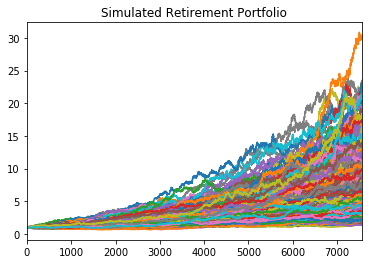

In [13]:
# Visualize the Simulation
monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio")

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_returns = monte_carlo.iloc[-1, :]

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_returns = monte_carlo.tail(1).T
ending_returns.head()

7560
0   8.629397
1   6.852970
2  10.134252
3  11.040280
4   9.587527

In [16]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_returns.quantile(q=[0.05, 0.95], numeric_only=True)
confidence_interval

7560
0.05   2.951375
0.95  16.019865

<Figure size 432x288 with 0 Axes>

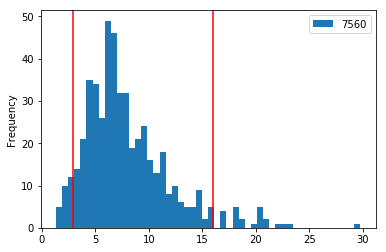

In [17]:
# Visualize the distribution of the ending returns
plt.figure();
ending_returns.plot.hist(bins=50)
plt.axvline(confidence_interval.iloc[0, 0], color='r')
plt.axvline(confidence_interval.iloc[1, 0], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [18]:
ending_returns.quantile([.01, .5, .9])

7560
0.01   1.966594
0.50   6.987007
0.90  13.175201

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [19]:
initial_investment = 20000 
initial_investment * ending_returns.quantile([.01, .5, .9])

7560
0.01   39331.887211
0.50  139740.145341
0.90  263504.013505

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [20]:
plaid_projected_annual_income =  7389

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = .04 * (initial_investment * ending_returns.quantile(.1)).iloc[0]

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= plaid_projected_annual_income:
    print(f"You will have ${retirement_income:.2f} in retirement income which is sufficient")
else:
    print(f"You will have ${retirement_income:.2f} in retirement income which is not sufficient")

You will have $3095.36 in retirement income which is not sufficient


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [21]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
.04 * (1.5 * initial_investment * ending_returns.quantile(.1)).iloc[0]

4643.038573462852

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [22]:
projected_returns = monte_carlo.quantile(q=[0.05, .5, .95], axis=1, numeric_only=True).T
projected_returns.head()

0.05      0.50      0.95
0  1.000000  1.000000  1.000000
1  0.990804  1.000359  1.010346
2  0.988008  1.000812  1.014196
3  0.984835  1.001241  1.018120
4  0.981904  1.001714  1.019833

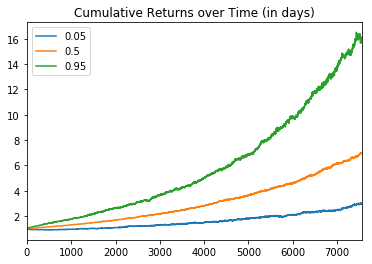

In [23]:
projected_returns.plot(title="Cumulative Returns over Time (in days)")

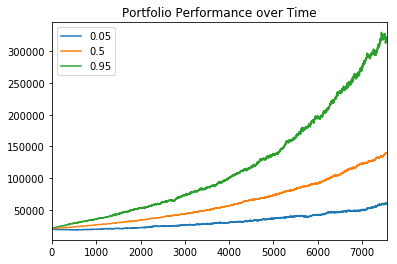

In [24]:
(initial_investment * projected_returns).plot(title="Portfolio Performance over Time")